# M1. Actividad - Arturo Sánchez Rodríguez - A01275427

In [26]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [27]:
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.cleaned_cells = 0

    def step(self):
        if self.model.is_dirty(self.pos):
            self.model.clean_cell(self.pos)
            self.cleaned_cells += 1

        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = random.choice(possible_steps)
        if self.model.grid.is_cell_empty(new_position):
            self.model.grid.move_agent(self, new_position)


In [28]:
class CleaningModel(Model):
    def __init__(self, N, width, height, dirty_percentage):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimultaneousActivation(self)
        self.running = True
        self.dirty_cells = set()

        for cell in self.grid.coord_iter():
            content, pos = cell
            if random.random() < dirty_percentage:
                self.dirty_cells.add(pos)

        for i in range(self.num_agents):
            a = CleaningAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            {
                "CleanedCells": lambda m: sum([a.cleaned_cells for a in m.schedule.agents]),
                "DirtyCells": lambda m: len(m.dirty_cells),
            }
        )

    def is_dirty(self, pos):
        return pos in self.dirty_cells

    def clean_cell(self, pos):
        if pos in self.dirty_cells:
            self.dirty_cells.remove(pos)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [29]:
width = 20
height = 20
dirty_percentage = 0.8
max_steps = 1500

agent_counts = [1, 5, 10]
results = []

for num_agents in agent_counts:
    model = CleaningModel(num_agents, width, height, dirty_percentage)
    for i in range(max_steps):
        model.step()
        if model.datacollector.get_model_vars_dataframe()["DirtyCells"].iloc[-1] == 0:
            break
    results.append(model.datacollector.get_model_vars_dataframe())


/var/folders/1b/8nqnwbjd0kzffk1mtbskrgbm0000gn/T/ipykernel_1065/4218605199.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Agentes: 1
Tiempo necesario hasta que todas las celdas estén limpias: 1500 pasos
Porcentaje de celdas limpias después de 500 pasos: 46.75
Porcentaje de celdas limpias después de 1000 pasos: 66.25
Porcentaje de celdas limpias después de 1500 pasos: 73.75


Agentes: 5
Tiempo necesario hasta que todas las celdas estén limpias: 576 pasos
Porcentaje de celdas limpias después de 500 pasos: 80.0
Porcentaje de celdas limpias después de 1000 pasos: N/A
Porcentaje de celdas limpias después de 1500 pasos: N/A


Agentes: 10
Tiempo necesario hasta que todas las celdas estén limpias: 387 pasos
Porcentaje de celdas limpias después de 500 pasos: N/A
Porcentaje de celdas limpias después de 1000 pasos: N/A
Porcentaje de celdas limpias después de 1500 pasos: N/A




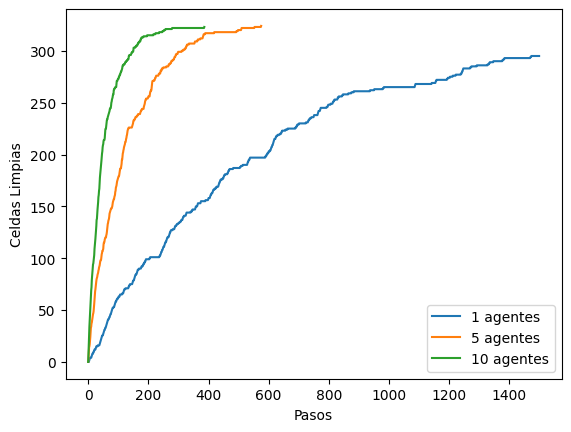

In [30]:
for num_agents, result in zip(agent_counts, results):
    print(f"Agentes: {num_agents}")
    print(f"Tiempo necesario hasta que todas las celdas estén limpias: {len(result)} pasos")
    print(f"Porcentaje de celdas limpias después de 500 pasos: {result['CleanedCells'].iloc[499] / (width * height) * 100 if len(result) > 499 else 'N/A'}")
    print(f"Porcentaje de celdas limpias después de 1000 pasos: {result['CleanedCells'].iloc[999] / (width * height) * 100 if len(result) > 999 else 'N/A'}")
    print(f"Porcentaje de celdas limpias después de 1500 pasos: {result['CleanedCells'].iloc[1499] / (width * height) * 100 if len(result) > 1499 else 'N/A'}")
    print("\n")

fig, ax = plt.subplots()
for num_agents, result in zip(agent_counts, results):
    ax.plot(result["CleanedCells"], label=f"{num_agents} agentes")
ax.set_xlabel("Pasos")
ax.set_ylabel("Celdas Limpias")
ax.legend()
plt.show()
